# SET: 23-9-15


In [75]:
# Importing standard data analysis and visualization libraries
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For advanced data visualization
import matplotlib.pyplot as plt  # For basic plotting and visualization
from scipy.stats import ttest_ind, mannwhitneyu  # For statistical tests
from sklearn.cluster import KMeans

# Importing custom utility functions for specific data processing tasks
from Utils_ipynb import (
    append_csv_files_from_subfolders,  # Function to concatenate CSV files from subfolders
    extract_and_append_image_info,  # Function to extract and append image information from data
    filter_dataframe,  # Function to filter data based on specific criteria
    get_correlation_matrices_plt,  # Function to create and plot correlation matrices
    refine_and_filter_data , # Function to refine and further filter data
    plot_metrics_by_group_and_ring
)

# Settings

In [76]:
RING_COEFF_CUT_OFF = 1.1

## Data Preparation

### Step 1: Data Read
- **Objective**: Combine 'cell_stat.csv' files from various subdirectories within a specified root folder into a single DataFrame.
- **Context**: This step aggregates data collected from parallel analyses conducted on the Borah cluster.
- **Data Format**: Each 'cell_stat.csv' file contains [brief description of data, like columns and typical values].
- **Note**: [Any specific filters or considerations applied during aggregation, if applicable].



In [77]:
# Read files from each subdirctory
root_folder = r'C:\Users\nnina\Documents\BioLab_C\Current_experiments_C\Anamaria_3d_experiment_C\23-9-15_v2\analysis_data'
combined_df = append_csv_files_from_subfolders(root_folder)
combined_df

,Image_name,Img_num,Cell_num,"Nucleus_volume, cubic_micrometre","Nucleus_cylinder, pixels_number","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 sum_pix_in_nuc_cylinder,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 sum_pix_in_nuc_cylinder,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 sum_pix_in_nuc_cylinder,AF488-T3 has ring,AF488-T3 ring intensity coef
0,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,0,0,387.682845,804672,23.133759,17.010117,3.22,3405.715272,1706593036,False,0.857249,1689.550044,1014969970,True,1.092949,3814.849142,2060917519,True,1.020733
1,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,0,1,367.317144,769464,23.048709,15.904460,3.45,3339.179969,1586577784,False,0.742296,2141.105358,1296103851,True,1.412558,3625.255595,1838598761,True,1.008106
2,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,0,2,403.430867,618930,17.435370,18.115775,3.91,6057.918194,2518832945,False,0.868496,1255.889380,666862193,True,1.404714,4669.589501,2096514022,True,1.048670
3,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,0,3,381.680944,614628,21.347697,14.118397,3.91,5947.099493,2312564857,False,0.853258,1462.962593,717213972,True,1.534575,4695.707357,1956057726,True,1.084201
4,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,1,0,931.329421,1517157,20.922444,25.770327,5.06,6456.557030,6253593754,False,0.841100,158.139155,215317404,False,0.922989,4797.999470,5147704476,True,1.032042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,20,2,404.474025,1146167,17.180218,20.412141,3.68,4018.647594,1900643916,False,0.842261,130.744368,110249829,False,0.913643,3937.642866,2085475174,False,0.712253
2474,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,20,3,321.889870,1105538,19.646685,18.115775,2.99,3671.468182,1620811486,False,0.930450,126.935876,97470539,False,0.967724,3196.380212,1578419137,False,0.794123
2475,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,20,4,963.424408,1871689,25.174973,22.963658,3.91,4829.071528,4487677287,False,0.747221,125.149628,193484650,False,0.948252,5046.616433,5051646198,False,0.833032
2476,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,20,5,748.690299,1476477,20.497191,22.368304,5.06,5249.275640,3984167012,False,0.763335,128.916544,154223767,False,0.925802,4786.560507,3887427903,False,0.880934


#### Step 2: Extraction of Experimental Setup and Group Information from Image Names
Extraction detailed information about the experimental setup and group, as well as the processing type, directly from the 'Image_name' column in our DataFrame. This is achieved through the extract_and_append_image_info function. The 'Image_name' column is a rich source of data, encapsulating key aspects of the experiment and image processing in a condensed format:
- Processing: Indicates the type of image processing used, such as 'RAW' or 'LSM'.
- Date: The date when the image was captured.
- Time: Time point of the experiment, typically 0, 24, or 48 hours.
- Cell Type: Identifies the cell type, e.g., 'KASH', 'KASH+doxy', or 'MSC'.
- LIV: Indicates the presence (+LIV) or absence (-LIV) of LIV in the sample.
- Cisp: Shows the concentration of Cisplatin used, or 'Control' if not applicable.

In [78]:
enhanced_df = extract_and_append_image_info(combined_df, 'Image_name')

#### Step 3: Removing Inaccurate Nuclei Detections
Although the 3D Signal Detector generally performs well in identifying signals within the nucleus area, manual verification of each image is still necessary. This step ensures the accurate processing of nuclei, particularly for retaining edge cells. While edge cells are often removed, some that are barely touching the image's edge may be viable for analysis and are, therefore, preserved.

Another challenge involves distinguishing between dividing nuclei and those with irregular shapes. While automation is possible for this task, we have chosen to assess the processed data manually. This assessment involves examining each image's maximum projection, focusing on specific cut-out areas and the mesh of nuclei.

Any cells identified for removal are listed in a CSV file with columns "Image_name" and "Cell_num". This file serves as a record of cells excluded from the analysis.

In [79]:
remove_nuclei_path = r"C:\Users\nnina\Documents\BioLab_C\Current_experiments_C\Anamaria_3d_experiment_C\23-9-15_v2\cells_to_remove.xlsx"
remove_df = pd.read_excel(remove_nuclei_path)
enhanced_remove_df = extract_and_append_image_info(remove_df, 'Image_name')

with pd.ExcelWriter(r'output_data_files/23-9-15-removed_cells_data.xlsx') as writer:
    enhanced_remove_df.to_excel(writer, index=False)

enhanced_remove_df

,Image_name,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Cell_num
0,LSM processed-23-9-15 KASH -LIV 10uM 6x vib 0h...,LSMprocessed-23-9-15KASH-LIV10uM6xvib0hr-19,LSM,23-9-15,0,KASH,-LIV,10um,2
1,LSM processed-23-9-15 KASH -LIV 10uM 6x vib 0h...,LSMprocessed-23-9-15KASH-LIV10uM6xvib0hr-32,LSM,23-9-15,0,KASH,-LIV,10um,0
2,LSM processed-23-9-15 KASH -LIV 10uM 6x vib 0h...,LSMprocessed-23-9-15KASH-LIV10uM6xvib0hr-32,LSM,23-9-15,0,KASH,-LIV,10um,1
3,LSM processed-23-9-15 KASH -LIV 10uM 6x vib 0h...,LSMprocessed-23-9-15KASH-LIV10uM6xvib0hr-32,LSM,23-9-15,0,KASH,-LIV,10um,2
4,LSM processed-23-9-15 KASH -LIV 10uM 6x vib 48...,LSMprocessed-23-9-15KASH-LIV10uM6xvib48hr-04,LSM,23-9-15,48,KASH,-LIV,10um,1
...,...,...,...,...,...,...,...,...,...
101,LSM processed-23-9-15 MSC -LIV -Cisplatin 0hr-...,LSMprocessed-23-9-15MSC-LIV-Cisplatin0hr-04,LSM,23-9-15,0,MSC,-LIV,-cisplatin,3
102,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 0hr...,LSMprocessed-23-9-15MSC+LIV10uM6xvib0hr-07,LSM,23-9-15,0,MSC,+LIV,10um,0
103,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-01,LSM,23-9-15,48,MSC,+LIV,10um,1
104,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-05,LSM,23-9-15,48,MSC,+LIV,10um,6


In [80]:
columns_to_compare = ['Base_image_name', 'Processing', 'Date', 'Time', 'Cell Type', 'LIV', 'Cisp', 'Cell_num']

# Perform a left anti join
enhanced_df = enhanced_df.merge(enhanced_remove_df[columns_to_compare], on=columns_to_compare, how='left', indicator=True)
enhanced_df = enhanced_df[enhanced_df['_merge'] == 'left_only'].drop('_merge', axis=1)
enhanced_df

,Image_name,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,...,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 sum_pix_in_nuc_cylinder,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 sum_pix_in_nuc_cylinder,AF488-T3 has ring,AF488-T3 ring intensity coef
0,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,0,...,False,0.857249,1689.550044,1014969970,True,1.092949,3814.849142,2060917519,True,1.020733
1,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,1,...,False,0.742296,2141.105358,1296103851,True,1.412558,3625.255595,1838598761,True,1.008106
2,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,2,...,False,0.868496,1255.889380,666862193,True,1.404714,4669.589501,2096514022,True,1.048670
3,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,3,...,False,0.853258,1462.962593,717213972,True,1.534575,4695.707357,1956057726,True,1.084201
4,LSM processed-23-9-15 KASH+doxy+LIV 10uM 6x vi...,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-12,LSM,23-9-15,0,KASH+doxy,+LIV,10um,1,0,...,False,0.841100,158.139155,215317404,False,0.922989,4797.999470,5147704476,True,1.032042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,2,...,False,0.842261,130.744368,110249829,False,0.913643,3937.642866,2085475174,False,0.712253
2474,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,3,...,False,0.930450,126.935876,97470539,False,0.967724,3196.380212,1578419137,False,0.794123
2475,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,4,...,False,0.747221,125.149628,193484650,False,0.948252,5046.616433,5051646198,False,0.833032
2476,LSM processed-23-9-15 MSC +LIV 10uM 6x vib 48h...,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,5,...,False,0.763335,128.916544,154223767,False,0.925802,4786.560507,3887427903,False,0.880934


## Step 4: Data Filtering and Refinement
In this section, we aim to streamline our dataset for more efficient analysis. The objectives are:
1. Remove any columns that are not relevant to our analysis to simplify the dataset.
2. Create new columns that will aid in deeper insights and facilitate a more thorough examination of the data.
3. Rename existing columns for clarity and better understanding. This involves modifying column names so that they accurately describe the data they represent, making the dataset more intuitive for anyone reviewing this analysis.


In [81]:
# Define the pixel size in microns
pixel_size = 0.085 * 0.085 * 0.230  # in cubic microns

refined_df = refine_and_filter_data(enhanced_df, pixel_size)

In [82]:
refined_df

,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,Nucleus_volume,Nucleus_height,Average_signal_594,Ring_coefficient,Average_signal_488,Total_signal_488,Group
0,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,0,387.682845,3.22,1689.550044,1.092949,3814.849142,8.899964e+08,KASH+doxy_+LIV_10um_0hr
1,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,1,367.317144,3.45,2141.105358,1.412558,3625.255595,8.013351e+08,KASH+doxy_+LIV_10um_0hr
2,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,2,403.430867,3.91,1255.889380,1.404714,4669.589501,1.133658e+09,KASH+doxy_+LIV_10um_0hr
3,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,3,381.680944,3.91,1462.962593,1.534575,4695.707357,1.078539e+09,KASH+doxy_+LIV_10um_0hr
4,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-12,LSM,23-9-15,0,KASH+doxy,+LIV,10um,1,0,931.329421,5.06,158.139155,0.922989,4797.999470,2.689044e+09,KASH+doxy_+LIV_10um_0hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,2,404.474025,3.68,130.744368,0.913643,3937.642866,9.584319e+08,MSC_+LIV_10um_48hr
2474,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,3,321.889870,2.99,126.935876,0.967724,3196.380212,6.191560e+08,MSC_+LIV_10um_48hr
2475,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,4,963.424408,3.91,125.149628,0.948252,5046.616433,2.925851e+09,MSC_+LIV_10um_48hr
2476,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,5,748.690299,5.06,128.916544,0.925802,4786.560507,2.156553e+09,MSC_+LIV_10um_48hr


In [83]:
refined_df.loc[:, "Ring"] = refined_df["Ring_coefficient"] >= RING_COEFF_CUT_OFF

# Initial Data Investigation

In [84]:
# Filter out rows where 'Processing' is 'RAW'
lsm_df = refined_df[refined_df['Processing'] != 'RAW']

# Group the filtered DataFrame based on the 'Group' column
grouped_lsm_df = lsm_df.groupby('Group')

# Aggregate the specified columns with count, mean, median, and std
aggregated_lsm_df = grouped_lsm_df.agg({
    'Nucleus_volume': ['count', 'mean', 'median', 'std'],
    'Nucleus_height': ['mean', 'median', 'std'],
    'Average_signal_488': ['mean', 'median', 'std'],
    'Total_signal_488': ['mean', 'median', 'std']
})

aggregated_lsm_df

#Save lsm_df data
with pd.ExcelWriter(r'output_data_files/23-9-15-aggregated-data.xlsx') as writer:
    lsm_df.to_excel(writer, index=False)

In [85]:
# Filter the DataFrame based on conditions
condition_kash_doxy = (lsm_df['Cell Type'] == 'KASH+doxy') & (lsm_df['Ring_coefficient'] > RING_COEFF_CUT_OFF)
condition_kash_msc = (lsm_df['Cell Type'].isin(['KASH', 'MSC'])) & (lsm_df['Ring_coefficient'] <= RING_COEFF_CUT_OFF)

final_df = lsm_df[condition_kash_doxy | condition_kash_msc]

final_df

,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,Nucleus_volume,Nucleus_height,Average_signal_594,Ring_coefficient,Average_signal_488,Total_signal_488,Group,Ring
1,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,1,367.317144,3.45,2141.105358,1.412558,3625.255595,8.013351e+08,KASH+doxy_+LIV_10um_0hr,True
2,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,2,403.430867,3.91,1255.889380,1.404714,4669.589501,1.133658e+09,KASH+doxy_+LIV_10um_0hr,True
3,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,LSM,23-9-15,0,KASH+doxy,+LIV,10um,0,3,381.680944,3.91,1462.962593,1.534575,4695.707357,1.078539e+09,KASH+doxy_+LIV_10um_0hr,True
5,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-12,LSM,23-9-15,0,KASH+doxy,+LIV,10um,1,1,494.643949,4.14,1305.371720,1.152295,6190.338675,1.842644e+09,KASH+doxy_+LIV_10um_0hr,True
6,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-12,LSM,23-9-15,0,KASH+doxy,+LIV,10um,1,2,525.887939,3.68,1243.153191,1.182661,4645.614905,1.470181e+09,KASH+doxy_+LIV_10um_0hr,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,2,404.474025,3.68,130.744368,0.913643,3937.642866,9.584319e+08,MSC_+LIV_10um_48hr,False
2474,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,3,321.889870,2.99,126.935876,0.967724,3196.380212,6.191560e+08,MSC_+LIV_10um_48hr,False
2475,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,4,963.424408,3.91,125.149628,0.948252,5046.616433,2.925851e+09,MSC_+LIV_10um_48hr,False
2476,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,LSM,23-9-15,48,MSC,+LIV,10um,20,5,748.690299,5.06,128.916544,0.925802,4786.560507,2.156553e+09,MSC_+LIV_10um_48hr,False


In [86]:
# Group the filtered DataFrame based on the 'Group' column
grouped_ring_filtered_lsm_df = final_df.groupby('Group')

# Aggregate the specified columns with count, mean, median, and std
aggregated_ring_filtered_lsm_df = grouped_ring_filtered_lsm_df.agg({
    'Nucleus_volume': ['count', 'mean', 'median', 'std'],
    'Nucleus_height': ['mean', 'median', 'std'],
    'Average_signal_488': ['mean', 'median', 'std'],
    'Total_signal_488': ['mean', 'median', 'std']
})

aggregated_ring_filtered_lsm_df

Nucleus_volume                            \
                                       count         mean       median   
Group                                                                    
KASH+doxy_+LIV_10um_0hr                   94   683.289132   570.255418   
KASH+doxy_+LIV_10um_24hr                 107   995.922599   882.773505   
KASH+doxy_+LIV_10um_48hr                  97   863.369568   598.621157   
KASH+doxy_-LIV_-cisplatin_0hr             84   634.661963   542.389630   
KASH+doxy_-LIV_10um_0hr                  106   812.360678   600.957032   
KASH+doxy_-LIV_10um_24hr                 117   933.471294   856.217071   
KASH+doxy_-LIV_10um_48hr                  92   860.078721   621.083571   
KASH_+LIV_10um_0hr                        97   509.425088   457.853921   
KASH_+LIV_10um_24hr                       86   860.112682   717.950835   
KASH_+LIV_10um_48hr                       68   870.992876   721.223389   
KASH_-LIV_-cisplatin_0hr                  93   525.556919   478.327764   
KASH_-LIV_10um_0hr                       105   729.047021   645.272104   
KASH_-LIV_10um_24hr                      102   790.010872   666.635625   
KASH_-LIV_10um_48hr                       83   747.541925   612.384351   
MSC_+LIV_10um_0hr                         82   593.111720   511.214685   
MSC_+LIV_10um_24hr                       100   697.270149   598.616166   
MSC_+LIV_10um_48hr                       122   726.506518   626.568052   
MSC_-LIV_-cisplatin_0hr                   98   595.757736   483.177949   
MSC_-LIV_10um_0hr                         89  1224.004004  1069.544497   
MSC_-LIV_10um_24hr                       109  1303.513460  1187.129340   
MSC_-LIV_10um_48hr                        95  1141.047949   954.462734   

                                          Nucleus_height                   \
                                      std           mean median       std   
Group                                                                       
KASH+doxy_+LIV_10um_0hr        329.763340       3.976064  3.910  0.495277   
KASH+doxy_+LIV_10um_24hr       457.774399       4.127103  4.140  0.639577   
KASH+doxy_+LIV_10um_48hr       509.178225       3.945567  3.680  0.763069   
KASH+doxy_-LIV_-cisplatin_0hr  292.317645       3.614286  3.450  0.628180   
KASH+doxy_-LIV_10um_0hr        551.448864       3.914340  3.680  0.745103   
KASH+doxy_-LIV_10um_24hr       483.984728       3.904103  3.910  0.547339   
KASH+doxy_-LIV_10um_48hr       503.255716       4.055000  3.910  0.631234   
KASH_+LIV_10um_0hr             212.857447       3.182062  3.220  0.643453   
KASH_+LIV_10um_24hr            458.956422       3.661279  3.565  0.656457   
KASH_+LIV_10um_48hr            440.546860       3.669853  3.680  0.585961   
KASH_-LIV_-cisplatin_0hr       214.707485       3.660215  3.680  0.582112   
KASH_-LIV_10um_0hr             357.240934       3.864000  3.680  0.702710   
KASH_-LIV_10um_24hr            527.952902       3.932549  3.910  0.799047   
KASH_-LIV_10um_48hr            498.629627       3.788072  3.680  0.705109   
MSC_+LIV_10um_0hr              268.807509       3.665976  3.565  0.747995   
MSC_+LIV_10um_24hr             367.242924       3.429300  3.450  0.716290   
MSC_+LIV_10um_48hr             472.141794       3.838361  3.680  0.622432   
MSC_-LIV_-cisplatin_0hr        280.361772       3.928776  3.910  0.782009   
MSC_-LIV_10um_0hr              608.059363       4.506966  4.140  0.997569   
MSC_-LIV_10um_24hr             634.664470       4.376330  4.140  0.746243   
MSC_-LIV_10um_48hr             690.167435       4.217474  4.140  0.670652   

                              Average_signal_488                            \
                                            mean       median          std   
Group                                                                        
KASH+doxy_+LIV_10um_0hr              4576.609068  4682.648429  1281.215774   
KASH+doxy_+LIV_10um_24hr             4788.316547  4585.970969  1393.377983   
KASH+doxy_+LIV

### Cell-Type Specific Scatter Plot Analysis

***Overview**
This section is dedicated to exploring the potential correlation between nuclear volume and signal intensity within different cell types. Specifically, we visualize two relationships for each unique cell type in our dataset:

'Nucleus Volume' vs 'Average Signal 488'
'Nucleus Volume' vs 'Total Signal 488'
For each cell type, separate scatter plots are generated, enabling a detailed and comparative analysis across varying cellular conditions.

**Objective**
The primary aim of these visualizations is to investigate whether there is a discernible correlation between the nucleus volume and signal intensity (both average and total). Understanding this relationship is crucial for assessing the impact of experimental variables, such as vibrations, on cellular repair mechanisms.

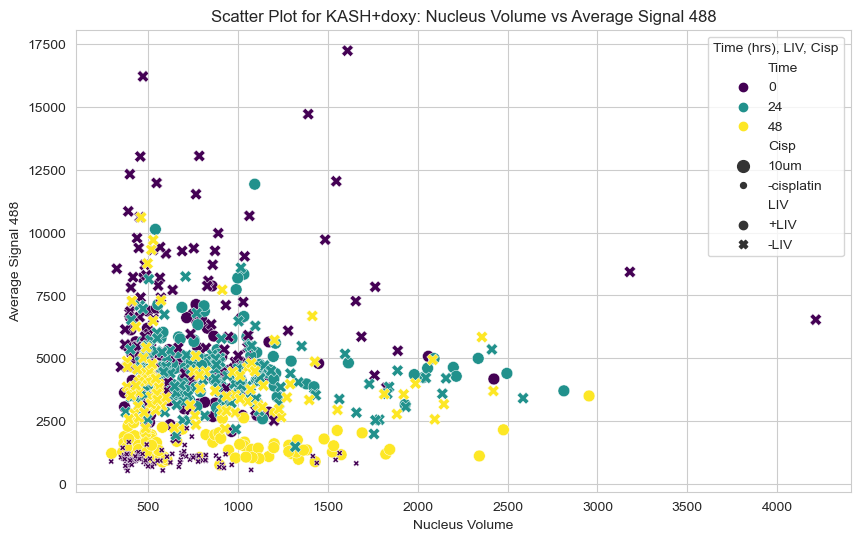

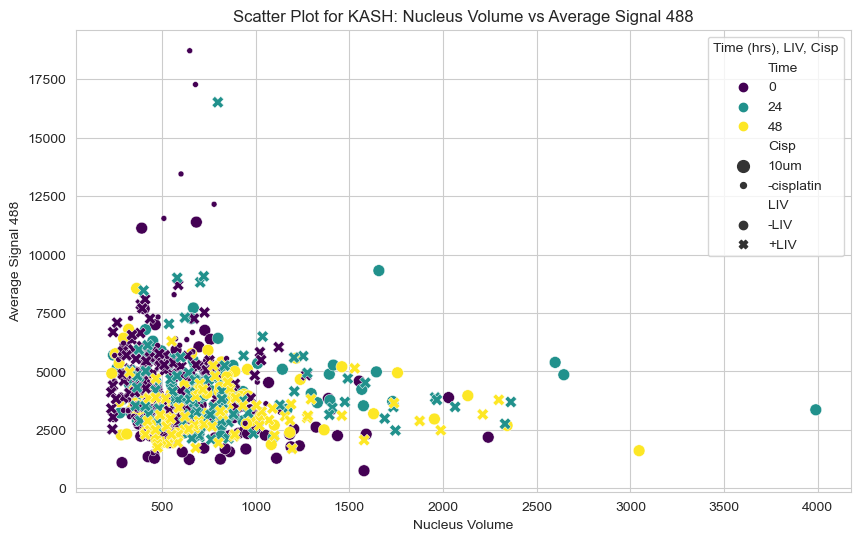

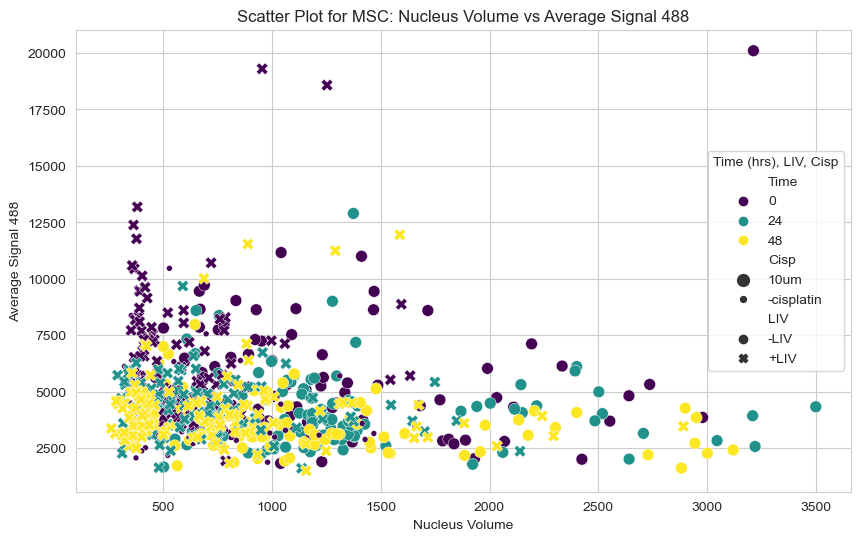

In [87]:
cell_types = final_df['Cell Type'].unique()

# Create a scatter plot for each cell type
for cell_type in cell_types:
    # Filter the DataFrame for the current cell type
    df_cell = final_df[final_df['Cell Type'] == cell_type]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_cell, x='Nucleus_volume', y='Average_signal_488',
                    hue='Time', style='LIV', size='Cisp', palette='viridis')

    # Adding plot title and labels
    plt.title(f'Scatter Plot for {cell_type}: Nucleus Volume vs Average Signal 488')
    plt.xlabel('Nucleus Volume')
    plt.ylabel('Average Signal 488')

    # Show the plot
    plt.legend(title='Time (hrs), LIV, Cisp')
    plt.show()

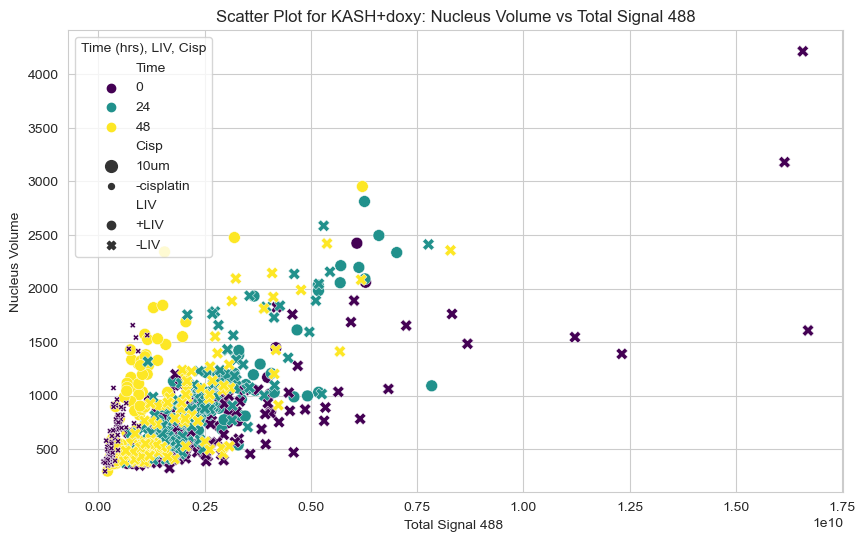

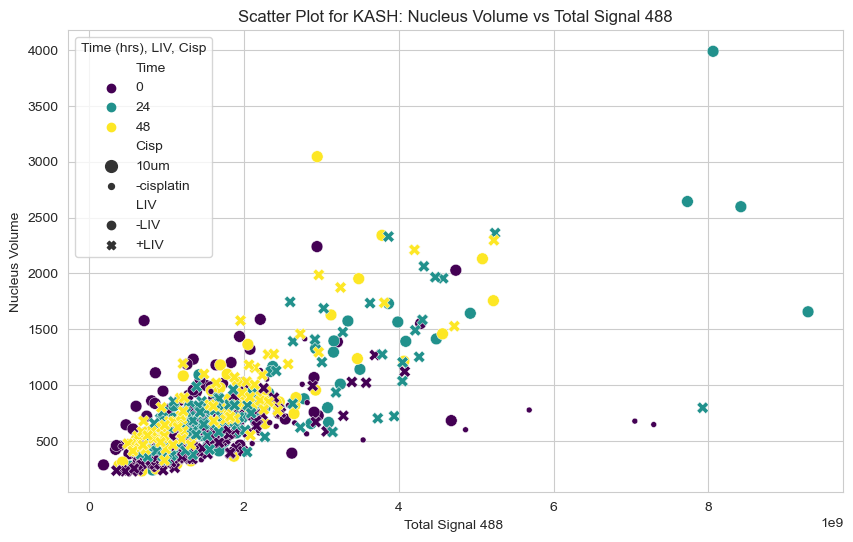

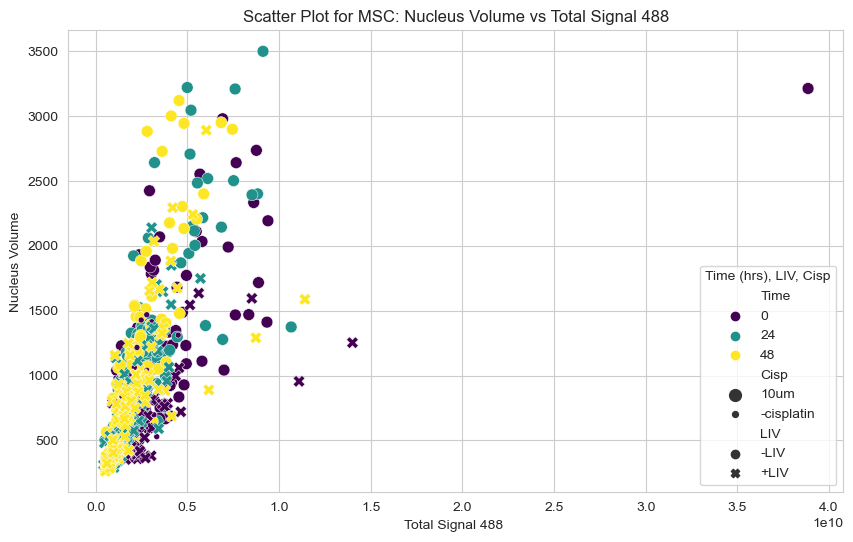

In [88]:
# Create a scatter plot for each cell type
for cell_type in cell_types:
    # Filter the DataFrame for the current cell type
    df_cell = final_df[final_df['Cell Type'] == cell_type]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_cell, x='Total_signal_488', y= 'Nucleus_volume',
                    hue='Time', style='LIV', size='Cisp', palette='viridis')

    # Adding plot title and labels
    plt.title(f'Scatter Plot for {cell_type}: Nucleus Volume vs Total Signal 488')
    plt.xlabel('Total Signal 488 ')
    plt.ylabel('Nucleus Volume')

    # Show the plot
    plt.legend(title='Time (hrs), LIV, Cisp')
    plt.show()

In [89]:
def calculate_correlations(df):
    correlation_avg_signal = df[['Nucleus_volume', 'Average_signal_488']].corr().iloc[0, 1]
    correlation_total_signal = df[['Nucleus_volume', 'Total_signal_488']].corr().iloc[0, 1]
    return pd.Series({'Correlation_Avg_Signal': correlation_avg_signal, 'Correlation_Total_Signal': correlation_total_signal})

# Group by 'Group' and apply the correlation function
correlation_table = final_df.groupby('Group').apply(calculate_correlations)

correlation_table


,Correlation_Avg_Signal,Correlation_Total_Signal
Group,,
KASH+doxy_+LIV_10um_0hr,-0.031500,0.842658
KASH+doxy_+LIV_10um_24hr,-0.125567,0.820171
KASH+doxy_+LIV_10um_48hr,0.119825,0.823718
KASH+doxy_-LIV_-cisplatin_0hr,-0.036078,0.825966
KASH+doxy_-LIV_10um_0hr,0.046542,0.813938
KASH+doxy_-LIV_10um_24hr,-0.239595,0.821350
KASH+doxy_-LIV_10um_48hr,-0.128794,0.831434
KASH_+LIV_10um_0hr,0.017820,0.849993
KASH_+LIV_10um_24hr,-0.162547,0.692674


C:\Users\nnina\AppData\Local\Temp\ipykernel_18408\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


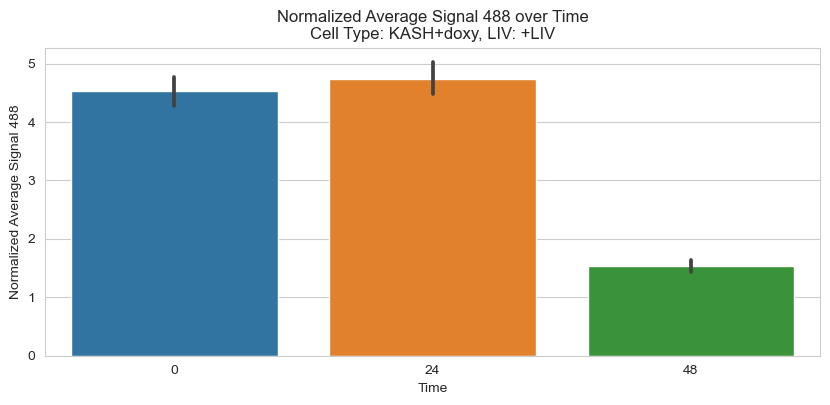

C:\Users\nnina\AppData\Local\Temp\ipykernel_18408\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


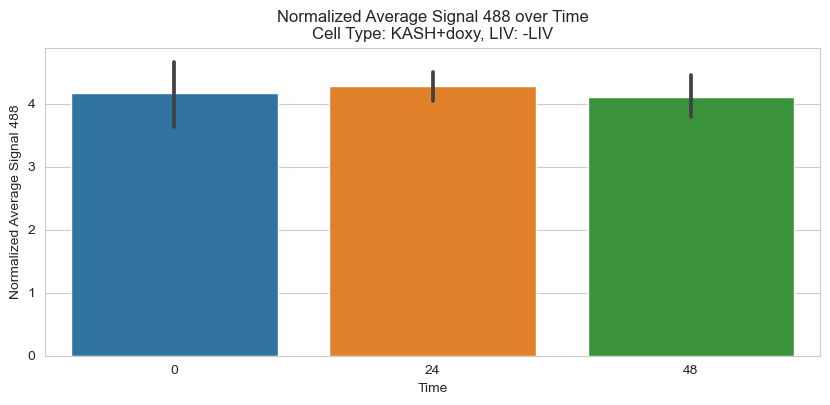

C:\Users\nnina\AppData\Local\Temp\ipykernel_18408\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


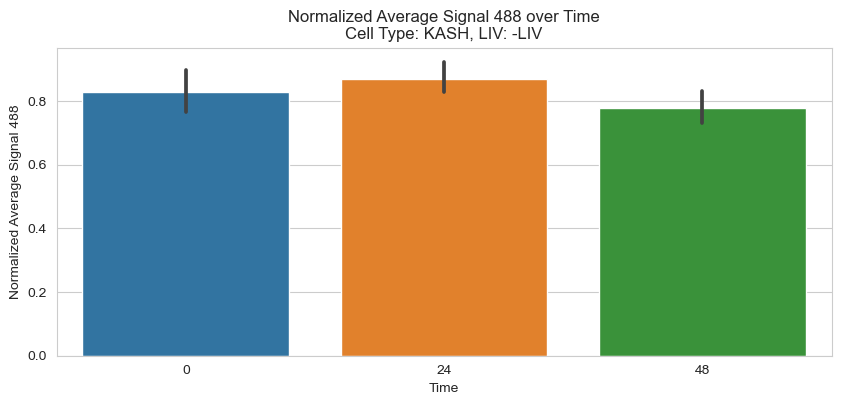

C:\Users\nnina\AppData\Local\Temp\ipykernel_18408\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


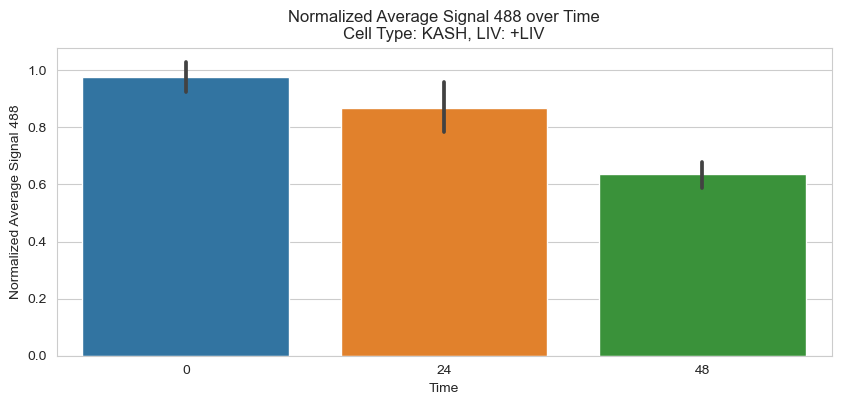

C:\Users\nnina\AppData\Local\Temp\ipykernel_18408\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


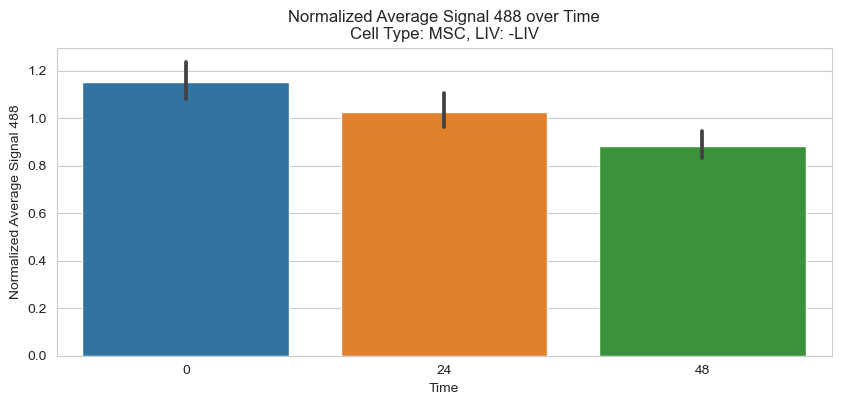

C:\Users\nnina\AppData\Local\Temp\ipykernel_18408\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


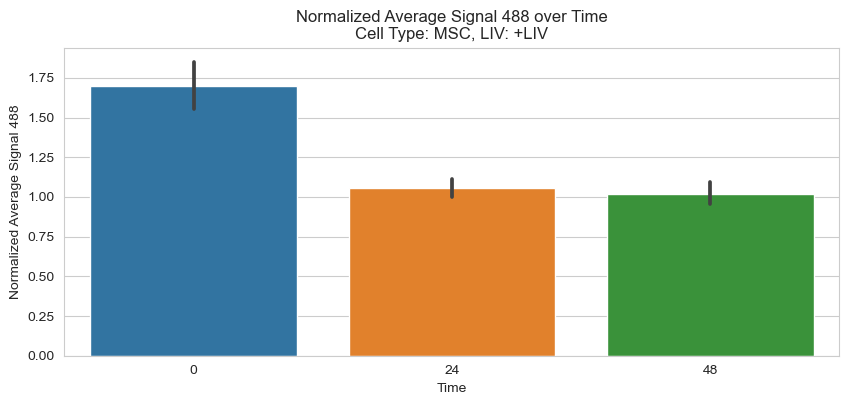

In [90]:
# Define the conditions for the bar charts
conditions = [
    {'Cell Type': 'KASH+doxy', 'LIV': '+LIV'},
    {'Cell Type': 'KASH+doxy', 'LIV': '-LIV'},
    {'Cell Type': 'KASH', 'LIV': '-LIV'},
    {'Cell Type': 'KASH', 'LIV': '+LIV'},
    {'Cell Type': 'MSC', 'LIV': '-LIV'},
    {'Cell Type': 'MSC', 'LIV': '+LIV'}
]

# Create bar charts
for condition in conditions:
    # Calculate the normalization factor based on condition
    normalization_factor = final_df[(final_df['Cell Type'] == condition['Cell Type']) &
                                    (final_df['Cisp'] == '-cisplatin') &
                                    (final_df['Time'] == 0) &
                                    (final_df['LIV'] == '-LIV')]['Average_signal_488'].mean()

    # Filter the DataFrame
    df_filtered = final_df[(final_df['Cell Type'] == condition['Cell Type']) &
                           (final_df['LIV'] == condition['LIV'])]

    # Normalize 'Average_signal_488'
    df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor

    # Plot
    plt.figure(figsize=(10, 4))
    sns.barplot(x='Time', y='Normalized_Avg_Signal_488', data=df_filtered)
    plt.title(f"Normalized Average Signal 488 over Time\nCell Type: {condition['Cell Type']}, LIV: {condition['LIV']}")
    plt.xlabel('Time')
    plt.ylabel('Normalized Average Signal 488')
    plt.show()


### Analysis of KASH+DOXY cells

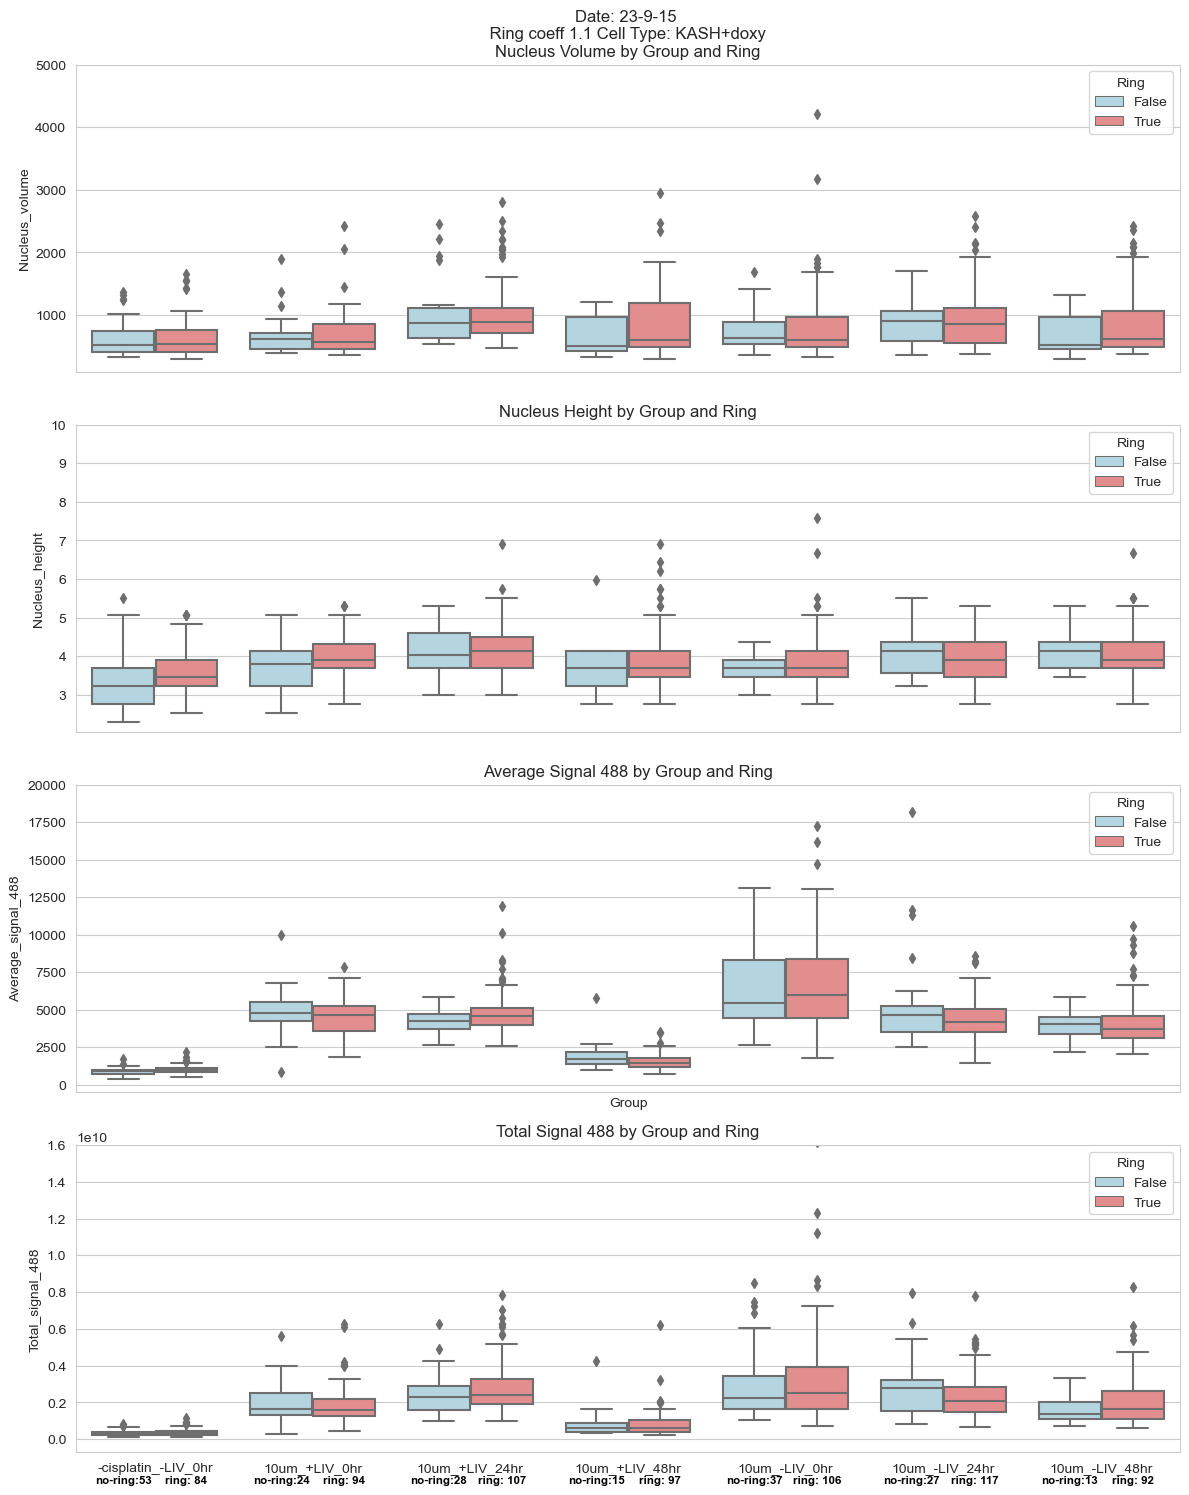

In [91]:
type_to_analyse = 'KASH+doxy'
fig = plot_metrics_by_group_and_ring(type_to_analyse, lsm_df, RING_COEFF_CUT_OFF,  color1="lightblue", color2="lightcoral",
                                     y_max_nucleus_volume=5000, y_max_nucleus_high=10, y_max_avg_signal_488=20000, y_max_total_signal_488=1.6e10)
plt.show()

### Analysis of KASH cells

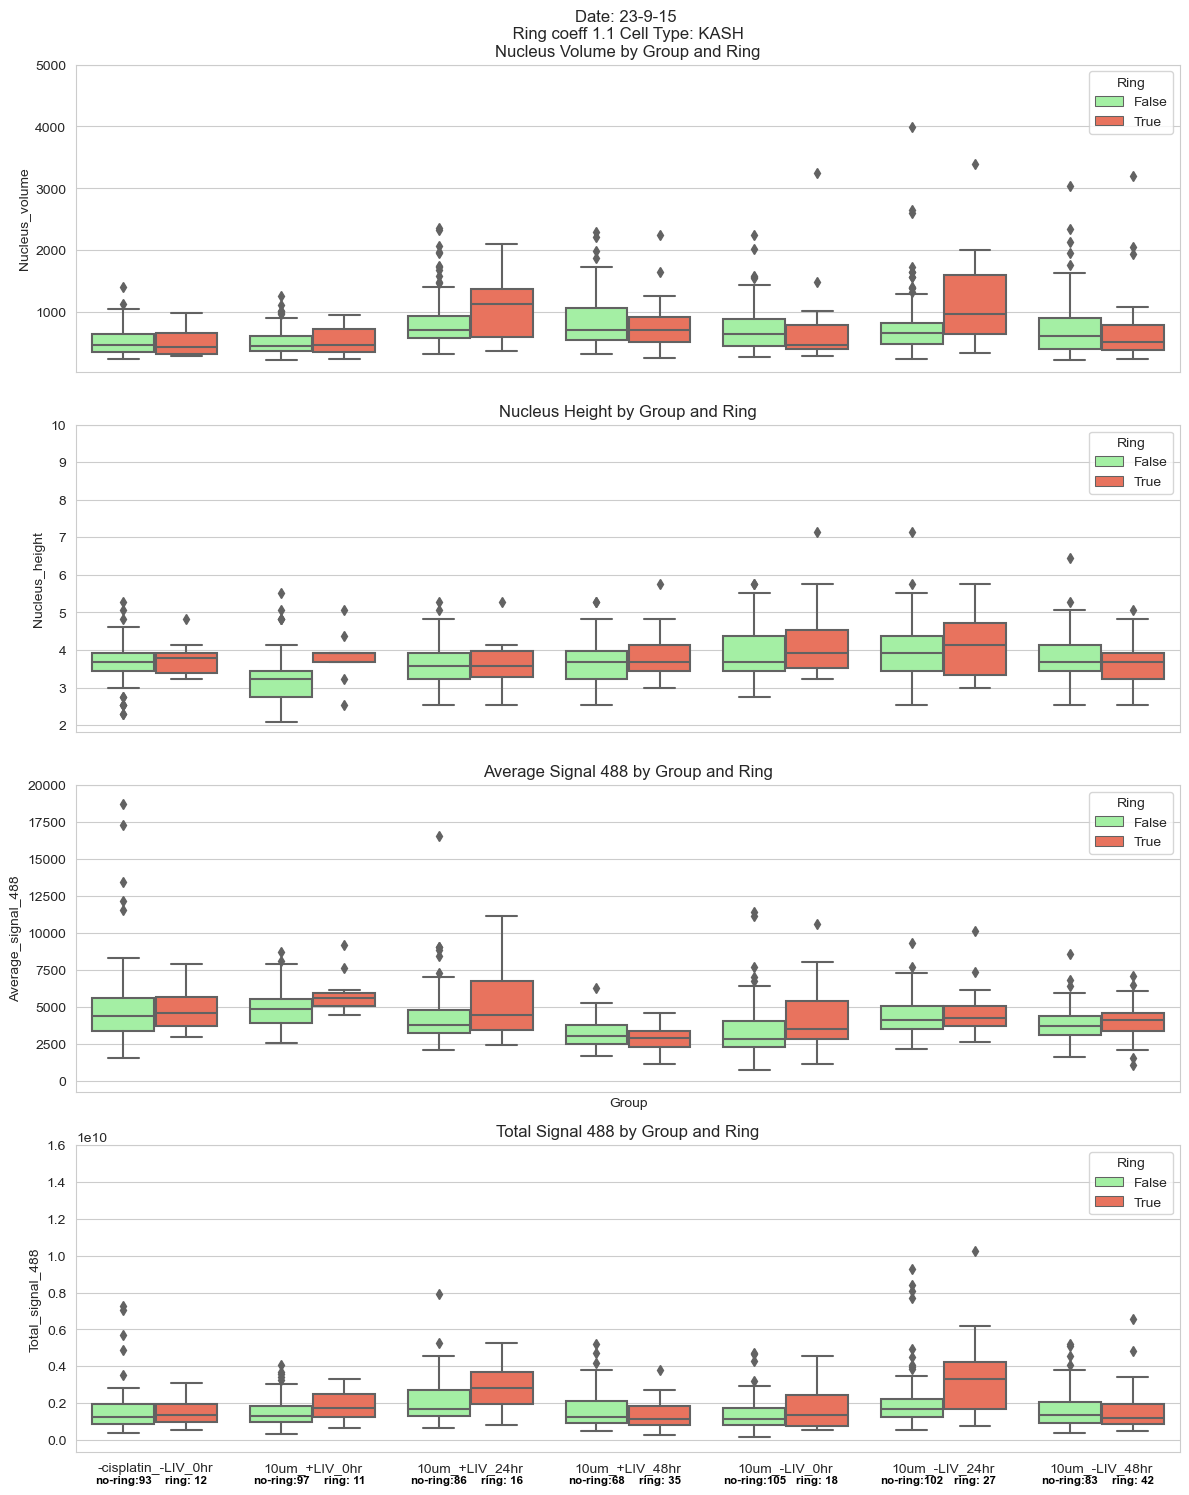

In [92]:
type_to_analyse = 'KASH'
fig = plot_metrics_by_group_and_ring(type_to_analyse, lsm_df, RING_COEFF_CUT_OFF,  color1="palegreen", color2="tomato",
                                     y_max_nucleus_volume=5000, y_max_nucleus_high=10, y_max_avg_signal_488=20000, y_max_total_signal_488=1.6e10)
plt.show()

### Analysis of MSC cells

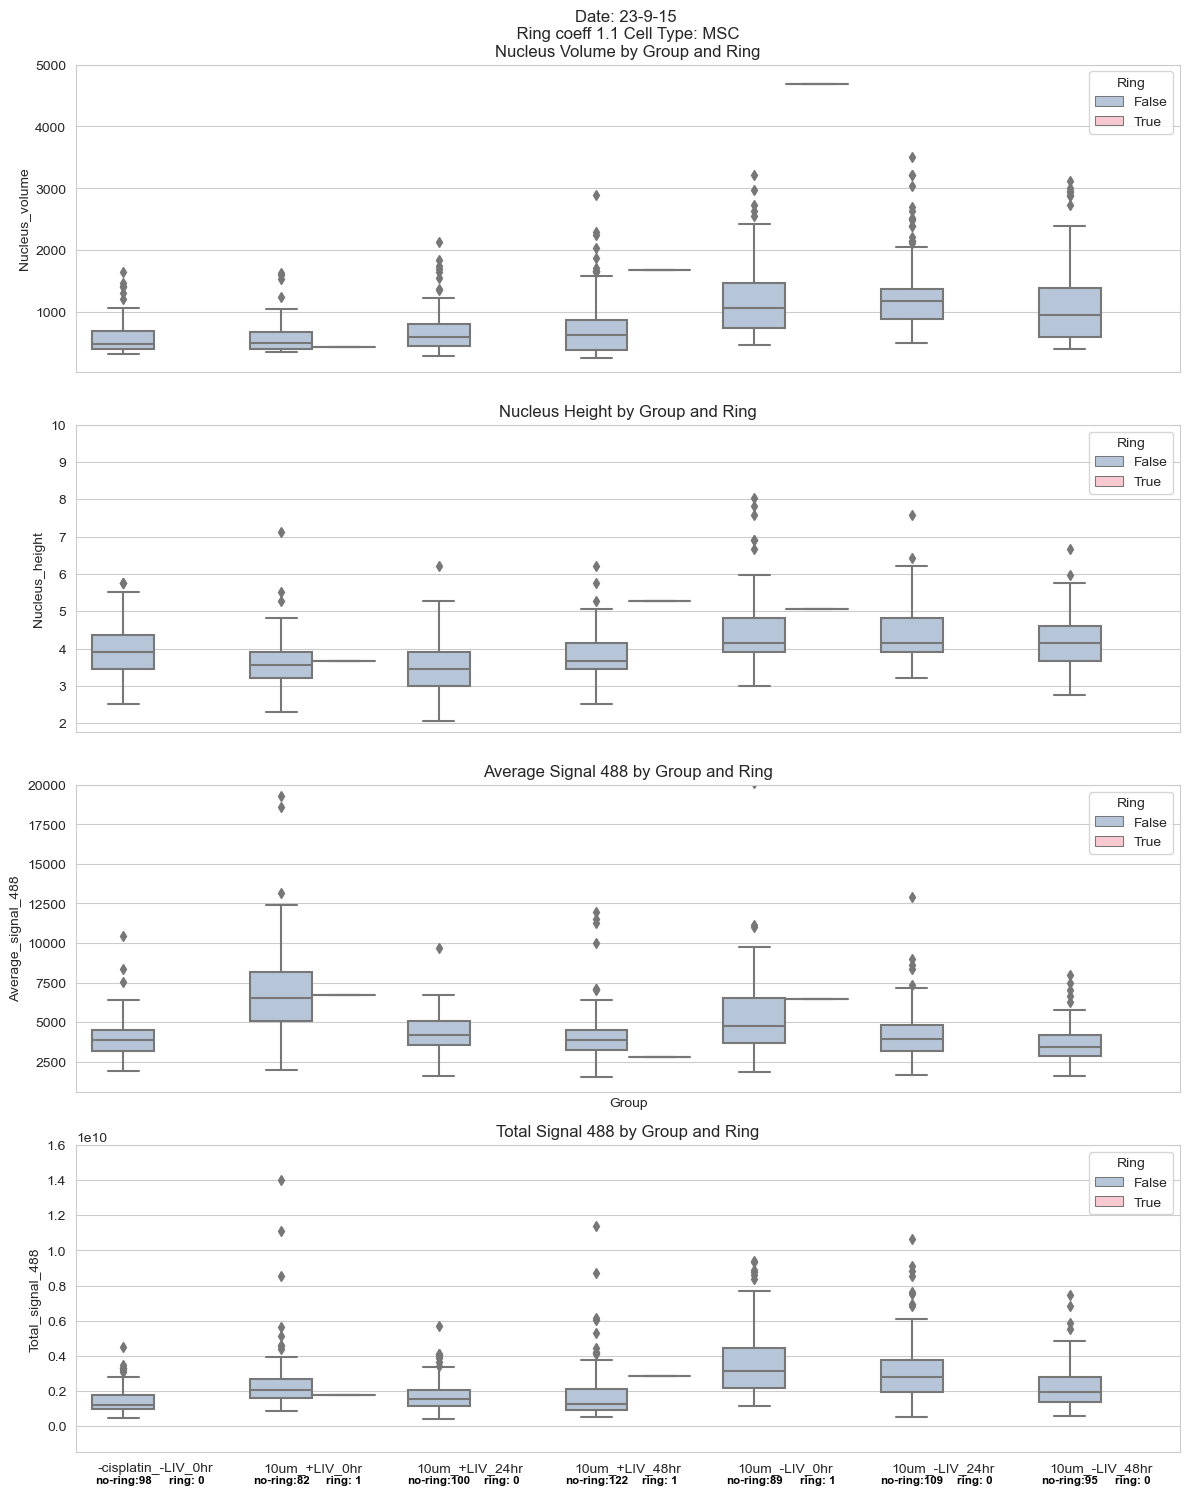

In [93]:
type_to_analyse = 'MSC'
fig = plot_metrics_by_group_and_ring(type_to_analyse, lsm_df, RING_COEFF_CUT_OFF,  color1="lightsteelblue", color2="pink",
                                     y_max_nucleus_volume=5000, y_max_nucleus_high=10, y_max_avg_signal_488=20000, y_max_total_signal_488=1.6e10)
plt.show()

In [94]:
### Investigate ring or no ring criterias

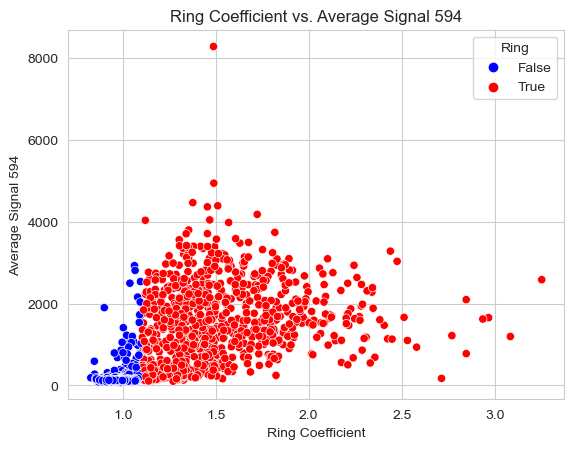

In [95]:
sns.scatterplot(data=lsm_df, x='Ring_coefficient', y='Average_signal_594', hue='Ring', palette=['blue', 'red'])

# Adding titles and labels for clarity
plt.title('Ring Coefficient vs. Average Signal 594')
plt.xlabel('Ring Coefficient')
plt.ylabel('Average Signal 594')

# Display the plot
plt.show()



In [96]:
# between 'Ring_coefficient' and 'Average_signal_594' for each group
grouped_correlation = lsm_df.groupby('Group')[['Ring_coefficient', 'Average_signal_594']].corr().iloc[0::2, -1].reset_index()

# Adjusting the columns for clarity
grouped_correlation.columns = ['Group', 'Variable', 'Correlation with Average_signal_594']
grouped_correlation = grouped_correlation.drop(columns=['Variable']).reset_index(drop=True)
grouped_correlation

,Group,Correlation with Average_signal_594
0,KASH+doxy_+LIV_10um_0hr,0.474342
1,KASH+doxy_+LIV_10um_24hr,0.338909
2,KASH+doxy_+LIV_10um_48hr,0.353131
3,KASH+doxy_-LIV_-cisplatin_0hr,0.522702
4,KASH+doxy_-LIV_10um_0hr,0.521752
5,KASH+doxy_-LIV_10um_24hr,0.336481
6,KASH+doxy_-LIV_10um_48hr,0.326694
7,KASH_+LIV_10um_0hr,0.222297
8,KASH_+LIV_10um_24hr,0.637238
9,KASH_+LIV_10um_48hr,0.566922


C:\Users\nnina\miniconda3\envs\mal_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\nnina\AppData\Local\Temp\ipykernel_18408\3234668246.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Cluster')


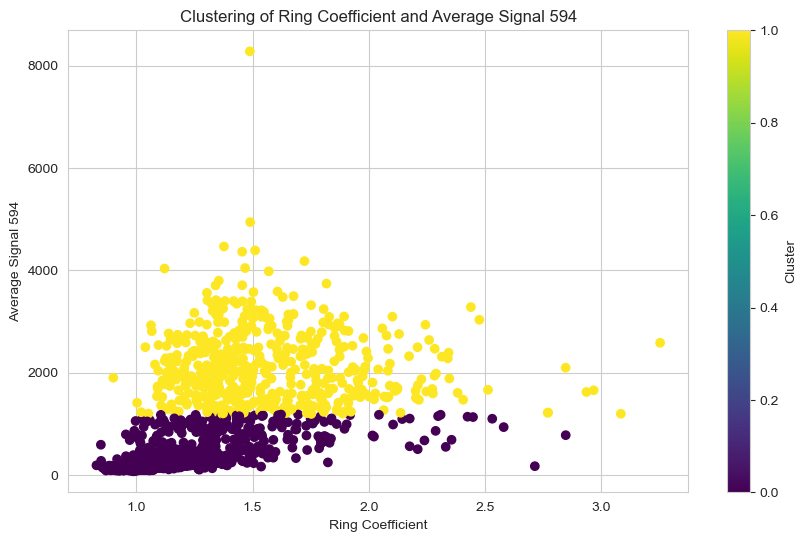

In [97]:
# Preparing data for clustering
X = lsm_df[['Ring_coefficient', 'Average_signal_594']]

# Applying K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Assigning cluster labels to the original data
lsm_df['Cluster'] = kmeans.labels_

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(lsm_df['Ring_coefficient'], lsm_df['Average_signal_594'], c=lsm_df['Cluster'], cmap='viridis', marker='o')
plt.title('Clustering of Ring Coefficient and Average Signal 594')
plt.xlabel('Ring Coefficient')
plt.ylabel('Average Signal 594')
plt.colorbar(label='Cluster')
plt.show()


## Subproject Overview
The objective of this project is to assess the presence or absence of a ring in the red channel of cells, utilizing a dataset comprising 41 3D czi images. This dataset encapsulates a total of 266 cells. The evaluation process will involve a detailed analysis conducted by two reviewers, Sean and Shayla, under the guidance of Anamaria. The analysis aims to categorize each cell based on the presence or absence of a ring on the red channel.

### Data Preparation and Methodology
#### Data Provision:
A comprehensive list detailing all 266 cells, inclusive of image names and cell numbers, will be provided. Additionally, png images with labeled cell numbers and the original czi images will be supplied for thorough investigation.
#### Training and Testing Sets:
The dataset will be randomly divided into two subsets: 80% for training (approximately 213 cells) and 20% for testing (approximately 53 cells).
### Analytical Methods
#### Threshold Analysis for 'Ring Coefficient':

This involves determining an optimal threshold for the "Ring Coefficient" using the training set. The decision might be supported by analyzing two histograms.

#### Clustering Approach:

A clustering method will be applied based on "Red Channel Intensity" and "Ring Coefficient". Analysis of a scatter plot, colored by the hue of human labeling, will help identify challenging cases and disagreements between reviewers.

#### Random Forest Model:

A random forest model will be developed, utilizing all available features. The impact of including the volume feature on the model's accuracy will also be explored.

### Accuracy Assessment
The accuracy of all three predictive methods will be calculated. Additionally, an innovative approach to assess human accuracy will be implemented, considering Sean's expertise as the benchmark (gold standard) and Shayla's input as representative of a novice researcher's perspective.
Professional Evaluation

### Strengths:
#### Comprehensive Data Analysis:
The project adopts a multi-faceted approach, employing statistical, clustering, and machine learning methods, which enhances the robustness of the findings.
#### Human Element:
Including human reviewers adds a valuable layer of qualitative analysis, enriching the dataset with expert and novice perspectives.

### Areas for Improvement:
#### Reviewer Bias Mitigation:
To further strengthen the study, incorporating more reviewers could help mitigate individual bias and provide a broader consensus on cell classification.
#### Automated Pre-Processing:
Implementing automated pre-processing steps to standardize images before analysis could reduce variability and improve model performance.
#### Cross-Validation:
Employing cross-validation techniques within the training set could offer a more reliable estimation of model performance and generalizability.

### Conclusion
The project's structured approach, combining human insight with advanced analytical techniques, sets a solid foundation for accurately classifying cells based on the presence or absence of a ring on the red channel. By addressing the suggested improvements, the project could further enhance its methodological rigor and the reliability of its findings.